## Setup

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [37]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Choose Cluster Number Here

In [66]:
cluster_num = 4

In [67]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(round(math.log(abs(num), 10)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  num += letters[scale]
  return num

def mpl_human_format(x, pos):
  if pos is not None:
    return human_format(x)

def make_axes_human_readable(ax, axis="y"):
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(matplotlib.ticker.FuncFormatter(mpl_human_format))
  return ax

## Import and process data

### Preprocess electricity usage clusters

In [68]:
# Load the electricity usage data
NUM_CLUSTERS = 4

cluster_dfs = list()

for i in range(1, NUM_CLUSTERS + 1):
    df = pd.concat([
        pd.read_parquet(f'drive/MyDrive/ieor-project1/dataset/cluster_{i}/training.parquet'),
        pd.read_parquet(f'drive/MyDrive/ieor-project1/dataset/cluster_{i}/validation.parquet'),
        pd.read_parquet(f'drive/MyDrive/ieor-project1/dataset/cluster_{i}/test.parquet'),
    ], axis=1).T.sort_index()
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    cluster_dfs.append(df)

In [69]:
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# fig.suptitle('Electricity usage by customer', fontweight='bold')

# for i, (ax, df) in enumerate(zip(axs.flatten(), cluster_dfs), start=1):
#     df.plot(ax=ax)

#     make_axes_human_readable(ax)
#     ax.set_title(f'Cluster {i}')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Daily electrcity usage (kWh)')
#     ax.grid(True, which='both')
#     ax.legend().remove()

# plt.tight_layout()
# plt.show()

In [70]:
# def plot_scaled_electrcity_usage(scaler, cluster_dfs):
#     fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

#     fig.suptitle(f'({scaler.__class__.__name__}) Electricity usage by customer', fontweight='bold')
#     for i, (ax, df) in enumerate(zip(axs.flatten(), cluster_dfs), start=1):
#         scaled_df = pd.DataFrame(
#             scaler.fit_transform(df),
#             columns=df.columns,
#             index=df.index
#         )
#         scaled_df.plot(ax=ax)
#         scaled_df.mean(axis=1).plot(ax=ax, color='black')

#         ax.set_title(f'Cluster {i}')
#         ax.set_xlabel('Date')
#         ax.set_ylabel('Daily electrcity usage')
#         ax.grid(True, which='both')
#         ax.legend().remove()

#     plt.tight_layout()
#     plt.show()

In [71]:
# scaler = MinMaxScaler()
# plot_scaled_electrcity_usage(scaler, cluster_dfs)

In [72]:
# scaler = StandardScaler()
# plot_scaled_electrcity_usage(scaler, cluster_dfs)

In [73]:
# scaler = RobustScaler()
# plot_scaled_electrcity_usage(scaler, cluster_dfs)

In [74]:
# scaler = FunctionTransformer(np.log1p, validate=True)
# scaler.__class__.__name__ = 'LogScaler'

# plot_scaled_electrcity_usage(scaler, cluster_dfs)

### Import the explanatory variables

In [75]:
explanatory_variables_df = pd.read_parquet('drive/MyDrive/ieor-project1/dataset/combined_explanatory_variables/explanatory_variables.parquet')
explanatory_variables_df.index = pd.to_datetime(explanatory_variables_df.index)
explanatory_variables_df = explanatory_variables_df.sort_index().asfreq('D')
explanatory_variables_df.head()

,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,,,,,,,
2012-01-01,6.578559,0.0,0.000,0.0,0,10.0,1
2012-01-02,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,7.437771,0.0,0.000,0.0,0,10.0,0


### Combine the electricity usage and explanatory variables

In [76]:
melted_dfs = list()
for i, df in enumerate(cluster_dfs, start=1):
    melted_df = pd.melt(df.reset_index(), id_vars=['date'], var_name='customer', value_name='electricity_usage')
    melted_df['cluster'] = i
    melted_dfs.append(melted_df)

combined_melted_df = pd.concat(melted_dfs, axis=0)
customer_level_dataset_df = pd.merge(combined_melted_df, explanatory_variables_df, on='date', how='inner')
customer_level_dataset_df = customer_level_dataset_df.set_index(['date', 'customer', 'cluster'])
customer_level_dataset_df.head()

,,,electricity_usage,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,customer,cluster,,,,,,,,
2012-01-02,MT_091,1,3141.260841,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,MT_091,1,3424.616411,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,MT_091,1,3465.810540,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,MT_091,1,3578.052035,7.437771,0.0,0.000,0.0,0,10.0,0
2012-01-06,MT_091,1,3697.965310,8.166583,0.0,0.000,0.0,0,10.0,0


In [77]:
scaler = StandardScaler()

cutoff_date = pd.to_datetime('2014-01-01')

boxcox_dfs = list()
scaled_dfs = list()
mean_series = list()
mean_train_series = list()
mean_test_series = list()

for df in cluster_dfs:
    boxcox_df = df.apply(lambda column: boxcox(column)[0])
    scaled_df = pd.DataFrame(
        scaler.fit_transform(boxcox_df),
        index=boxcox_df.index,
        columns=boxcox_df.columns
    )
    mean = scaled_df.mean(axis=1)
    mean_train = mean[mean.index < cutoff_date]
    mean_test = mean[mean.index >= cutoff_date]
    boxcox_dfs.append(boxcox_df)
    scaled_dfs.append(scaled_df)
    mean_series.append(mean)
    mean_train_series.append(mean_train)
    mean_test_series.append(mean_test)

# Prepare Data for LSTM-RNN

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [79]:
cluster_df = customer_level_dataset_df.xs(cluster_num, level='cluster')
cluster_df

,,electricity_usage,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,customer,,,,,,,,
2012-01-02,MT_014,1061.263561,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,MT_014,1531.908105,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,MT_014,1649.808551,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,MT_014,1525.686024,7.437771,0.0,0.000,0.0,0,10.0,0
2012-01-06,MT_014,1526.005105,8.166583,0.0,0.000,0.0,0,10.0,0
...,...,...,...,...,...,...,...,...,...
2014-12-27,MT_164,2261.053795,9.032632,0.0,0.000,0.0,0,9.0,1
2014-12-28,MT_164,1951.363301,7.697900,0.0,0.000,0.0,0,9.0,1
2014-12-29,MT_164,3478.813559,10.921202,0.0,0.000,0.0,0,9.0,0


In [80]:
# do train test split with cluster_df
train_df = cluster_df[cluster_df.index.get_level_values('date') < cutoff_date]
test_df = cluster_df[cluster_df.index.get_level_values('date') >= cutoff_date]

In [81]:
train_df

,,electricity_usage,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,customer,,,,,,,,
2012-01-02,MT_014,1061.263561,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,MT_014,1531.908105,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,MT_014,1649.808551,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,MT_014,1525.686024,7.437771,0.0,0.000,0.0,0,10.0,0
2012-01-06,MT_014,1526.005105,8.166583,0.0,0.000,0.0,0,10.0,0
...,...,...,...,...,...,...,...,...,...
2013-12-27,MT_164,3943.072955,5.549002,0.0,0.048,1.0,0,9.0,0
2013-12-28,MT_164,2890.751658,8.432045,0.0,0.101,1.0,0,9.0,1
2013-12-29,MT_164,2017.133382,9.526014,0.0,0.006,1.0,0,9.0,1


In [82]:
# create correlation matrix by color and drop features
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')


,electricity_usage,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
electricity_usage,1.000000,0.178197,-0.106736,0.018658,0.042271,-0.044055,-0.165533,-0.219503
heating_degree_days,0.178197,1.000000,-0.573343,0.087076,0.215837,0.030624,-0.684717,0.020313
cooling_degree_days,-0.106736,-0.573343,1.000000,-0.159922,-0.285467,-0.050482,0.462142,-0.016394
precip,0.018658,0.087076,-0.159922,1.000000,0.514216,0.083375,-0.161296,0.012477
precipprob,0.042271,0.215837,-0.285467,0.514216,1.000000,0.068739,-0.227827,-0.012645
is_holiday,-0.044055,0.030624,-0.050482,0.083375,0.068739,1.000000,0.032473,0.005603
sunlight_length_hours,-0.165533,-0.684717,0.462142,-0.161296,-0.227827,0.032473,1.000000,-0.001838
is_weekend,-0.219503,0.020313,-0.016394,0.012477,-0.012645,0.005603,-0.001838,1.000000


In [83]:
highly_correlated = set()  # Use a set to store correlated columns
for i in range(len(corr.columns)):
  for j in range(i):
    if abs(corr.iloc[i, j]) > 0.8:
      print(corr.columns[i], corr.columns[j])
      colname = corr.columns[j]
      highly_correlated.add(colname)
train_df = train_df.drop(columns=highly_correlated)
test_df = test_df.drop(columns=highly_correlated)
train_df

,,electricity_usage,heating_degree_days,cooling_degree_days,precip,precipprob,is_holiday,sunlight_length_hours,is_weekend
date,customer,,,,,,,,
2012-01-02,MT_014,1061.263561,6.659918,0.0,0.111,1.0,0,10.0,0
2012-01-03,MT_014,1531.908105,7.977833,0.0,0.000,0.0,0,10.0,0
2012-01-04,MT_014,1649.808551,6.335269,0.0,0.000,0.0,0,10.0,0
2012-01-05,MT_014,1525.686024,7.437771,0.0,0.000,0.0,0,10.0,0
2012-01-06,MT_014,1526.005105,8.166583,0.0,0.000,0.0,0,10.0,0
...,...,...,...,...,...,...,...,...,...
2013-12-27,MT_164,3943.072955,5.549002,0.0,0.048,1.0,0,9.0,0
2013-12-28,MT_164,2890.751658,8.432045,0.0,0.101,1.0,0,9.0,1
2013-12-29,MT_164,2017.133382,9.526014,0.0,0.006,1.0,0,9.0,1


In [84]:
test_df
# count frequency per customer for test_df
test_df.groupby('customer').size()

,0
customer,
MT_014,365
MT_077,365
MT_095,365
MT_096,365
MT_164,365


In [85]:
print(train_df.shape)
print(test_df.shape)

(3650, 8)
(1825, 8)


In [86]:
def create_sequence(df, sequence_length=30, target_length=7):
    X, y = [], []
    feature_columns = df.columns.tolist()
    # make sure customers don't overlap
    customer_ids = df.index.get_level_values('customer').unique()
    for customer_id in customer_ids:
        customer_data = df.loc[pd.IndexSlice[:, customer_id], :]
        # Create sequences for the current customer's data
        for i in range(len(customer_data) - sequence_length - target_length):
            past_data = customer_data.iloc[i:i + sequence_length].values
            X.append(past_data)
            y.append(customer_data.iloc[i + sequence_length:i + sequence_length + target_length]['electricity_usage'].values)
    return np.array(X), np.array(y)
# Define parameters
sequence_length = 30
target_length = 7

# Generate sequences
X_train, y_train = create_sequence(train_df, sequence_length, target_length)
X_test, y_test = create_sequence(test_df, sequence_length, target_length)

# X_train.shape = (num_samples, sequence_length, num_features)
X_train.shape, y_train.shape

((3465, 30, 8), (3465, 7))

In [87]:
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / K.clip(y_true, 1e-7, None))) * 100

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-7, None))) * 100

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length + target_length, 8)),
    LSTM(50, activation='relu'),
    Dense(target_length)  # Output matches `target_length` days
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mape'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 37, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             357 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,357 (126.39 KB)

 Trainable params: 32,357 (126.39 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.4, verbose=1)

Epoch 1/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 689715.3125 - mape: 94.5707 - val_loss: 2003331.5000 - val_mape: 64.7804
Epoch 2/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 311909.9062 - mape: 63.1912 - val_loss: 446404.4375 - val_mape: 37.0483
Epoch 3/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 73957.1719 - mape: 41.4424 - val_loss: 324253.2500 - val_mape: 31.3703
Epoch 4/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 65080.2500 - mape: 39.2347 - val_loss: 951042.0625 - val_mape: 44.5018
Epoch 5/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 145349.4531 - mape: 49.5944 - val_loss: 314283.9375 - val_mape: 33.5136
Epoch 6/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 51338.1133 - mape: 41.1061 - val_loss: 261865.8750 - val_mape: 31.1071
Epoch 7/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 44891.7305 - mape: 38.8634 - val_loss: 254711.2656 - val_mape: 31.0091
Epoch 8/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 45432.3164 - ma

In [89]:
# Predict on test set
y_pred = model.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MAPE: {test_mape:.2f}%")

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Test MAPE: 36.66%


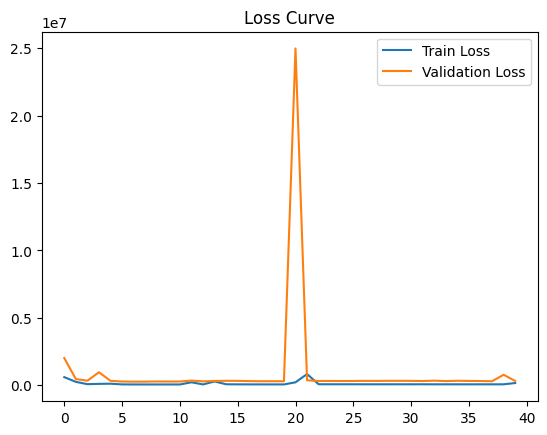

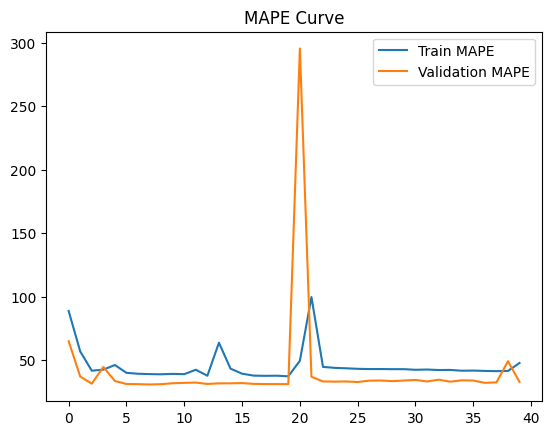

In [90]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.plot(history.history['mape'], label='Train MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.legend()
plt.title('MAPE Curve')
plt.show()

In [91]:
X_test.shape

(1640, 30, 8)

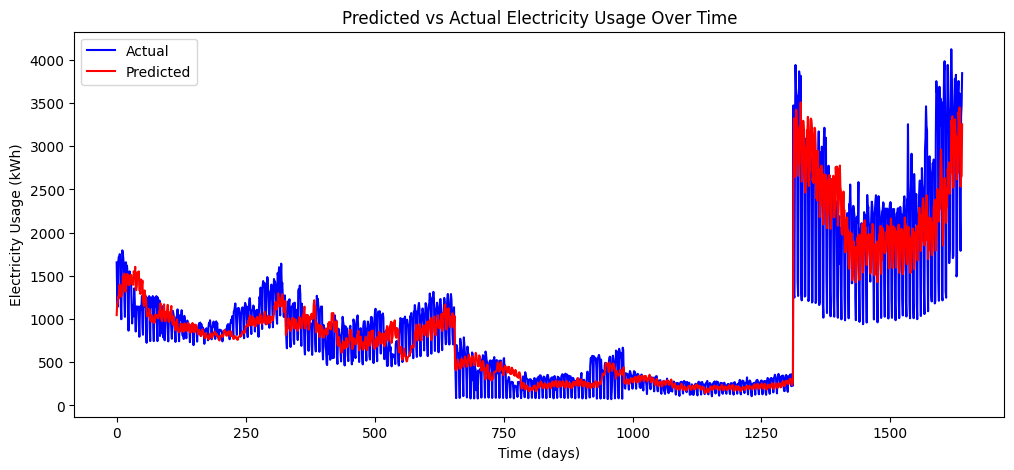

In [92]:
# flatten to avoid overlaps
y_pred_filtered = y_pred[:, 0]
y_test_filtered = y_test[:, 0]
time_index = np.arange(len(y_pred_filtered))

plt.figure(figsize=(12, 5))
plt.plot(time_index, y_test_filtered, label="Actual", linestyle="-", color="blue")
plt.plot(time_index, y_pred_filtered, label="Predicted", linestyle="-", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Electricity Usage (kWh)")
plt.legend()
plt.title("Predicted vs Actual Electricity Usage Over Time")
plt.show()

In [93]:
# save history for training as csv
history_df = pd.DataFrame({
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'mape': history.history['mape'],
    'val_mape': history.history['val_mape']
})
history_df.to_csv(f'drive/MyDrive/ieor-project1/dataset/history_rnn_cluster{cluster_num}.csv', index=False)

results_df = pd.DataFrame({
    'y_test': y_test_filtered,
    'y_pred': y_pred_filtered
})
results_df.to_csv(f'drive/MyDrive/ieor-project1/dataset/results_rnn_cluster{cluster_num}.csv', index=False)

mape_values = np.abs((y_test - y_pred) / y_test) * 100
np.savetxt(f'drive/MyDrive/ieor-project1/dataset/mape_rnn_cluster{cluster_num}.csv', mape_values, delimiter=',')

In [93]:
# not to include lstm architecture, just the pipeline